# <center> Causal Inference with Python
### <center>"Randomized experiments from non-random selection in U.S. House elections" by David S. Lee
#### <center>Paper replication by Ben Albrecht
##### Summary:
In this Jupyter Notebook, I will replicate the results of David S. Lee's paper "Randomized Experiments from Non-random Selection in U.S. House Elections" in the Journal of Econometrics. This is a simple introduction to regression discontinuities and a Python data processing and analysis exercise. Pandas will be the primary library used. However, we will also use NumPy, Matplotlib, and Statsmodels.
##### Part I: Introduction
Regression discontinuity design (RDD) is a quasi-experimental method in causal inference. An RDD aims to identify the effect of some binary treatment $x_i$ on an outcome $y_i$. In its first application, Thistlethwaite and Campbell (1960) explored the effect of scholarships on student careers. Here, we will explore David S. Lee's use of the RDD in identifying the effect of incumbency on political candidates. 

In U.S. House elections, officials are elected through a first-past-the-post (FPTP or FPP) voting system, meaning that the candidate who receives the most votes wins. Here, we are interested in the treatment effect of incumbency on winning re-election. So, the binary treatment $x_i$ is 1 for incumbent politicians and 0 for non-incumbents. The primary identification problem is that candidates receive or do not receive treatment. No candidate is observed as both winning and losing an election simultaneously. 

For a candidate $i$, let $y_{1i}$ be their outcome with treatment (outcome of the election as incumbent), and $y_{0i}$ be their outcome with the absence of treatment. We can then write the model for observed outcomes as follows:
$$
y_i = \alpha_i + x_i \cdot \beta_i
$$
where $\alpha:=y_{0i}$ and $\beta:=y_{1i} - y_{0i}$. Note that $\beta_i$ is the difference between treated and untreated outcomes for candidate i, which we aim to estimate.

Define the candidate's voting score, denoted $V$, which is conditional on the actions and attributes of a candidate as well as stochasticity in the election (noise, randomness). A candidate can influence their score $V$ by choices within the election: policy platforms, campaign staffing and spending, where and how to campaign, etc., and their characteristics. Assume that the probability density of $V$ is continuous, conditional on the candidate's choices and characteristics. Note that this $V$ is unobserved and heterogeneous across individuals. We can't observe the distribution of outcomes for all candidates; we can only observe the result of the election they participate in.

In this paper, Lee utilizes what is called a sharp RDD. A sharp RDD is one where $x_i$ depends in a deterministic way on some observable $v_i$, $x_i = f(v_i)$, where $v_i$ is a continuous value. At some point, the function $f(\cdot)$ presents a discontinuity at point $v_0$ where treatment is assigned. In Lee's paper, $v_i$ is the candidate's vote share drawn from the previously defined random variable $V_i$ (voting score). The step function $f(\cdot)$ assigns treatment when the candidate wins their election. 
$$
x_i = f(v_i) = \begin{cases}
                            1 & \text{if $v_i > 0.5$} \\
                            0 & \text{if $v_i \leq 0.5$}
                \end{cases}
$$
In sum, a candidate becomes an incumbent if and only if $v_i > v_0$, where $v_0=0.5$. The key to an RDD is that close to this threshold, variables determined before treatment should be independent of treatment status. In other words, the differences between candidate $i$, who receives $0.5001$ percent of the vote, and candidate $j$, who receives $0.4999$ percent of the vote, are minuscule. While candidates certainly influence the outcome, inherent uncertainty also partially determines the outcome, especially in tight races.

##### Part II: Design Verification
First, we will verify that this is a sharp RDD. To do so, we must first generate the "forcing variable," or our $v_i$ votes that the candidate receives, and then determine their treatment outcome. Before doing so, we must import the libraries we plan to use, read our data, and process it for analysis.

In [31]:
# Import libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Functions I made for ease.
import my_functions

# Read data.
data = pd.read_csv('lee_data.csv')


""" Variable Descriptions:
-> state: state code
-> distnum: congressional district number (for each state)
-> distid: congressional district id (nationwide)
-> party: party code (100 = Democrats, 200 = Republicans)
-> partname: party name
-> yearel: year of election
-> origvote: votes each candidate received
-> totvote: total votes cast in each district in a given year
-> highestvote: votes for candidate who received the largest votes in a district, in a given year
-> sechighestvote: votes for candidate who received second largest votes
-> officeexp: terms a house representative have served
"""


# Examine the data.
data.head(5)

,state,distnum,distid,party,partname,yearel,origvote,totvote,highestvote,sechighestvote,uniqid,officeexp
0,1,1,1,100,D,1946,82231.0,175237.0,93006.0,82231.0,15937,0
1,1,1,1,200,R,1946,93006.0,175237.0,93006.0,82231.0,19281,0
2,1,1,1,100,D,1948,127802.0,233700.0,127802.0,103294.0,23403,0
3,1,1,1,200,R,1948,103294.0,233700.0,127802.0,103294.0,19281,1
4,1,1,1,100,D,1950,134258.0,231096.0,134258.0,96251.0,23403,1


In [32]:
# Create share of the vote for candidates
data['share'] = data['origvote'] / data['totvote']


# Share of the vote for 1st highest vote receiver, and 2nd highest vote receiver.
data['1st_share'] = data['highestvote'] / data['totvote']
data['2nd_share'] = data['sechighestvote'] / data['totvote']


# Create column to map years to which decade they are in.
# Our data contains elections from the 1940s to the 90s.
data['decade'] = data['yearel'].apply(my_functions.map_decade)

# Creating treatment indicator.
data['win'] = np.where(data['share'] == data['1st_share'], 1, 0)

Now that we have processed our data, we will create the forcing variable. In almost all U.S. House elections, the strongest two parties, the Republicans and Democrats, are the real competitors. While third parties get some share of the vote, they often cannot compete. U.S. election analysis should always use the two-party vote share rather than the total. We will use this approach here. Another nuance in U.S. elections is that redistricting occurs every ten years. We need both lags and leads of the vote margin, so we'll drop years that end in both 0 and 2.

Because the cutoff can't be exactly $50%$ in all cases, our forcing variable will be the Democratic vote share minus the share of the strongest opponent. This gives us the Democratic vote share margin of victory. A Democrat wins the election when this crosses the $0$ threshold.

Furthermore, a candidate may choose not to re-run in an election. To correct this, we will analyze the incumbency advantage for parties at the district level.

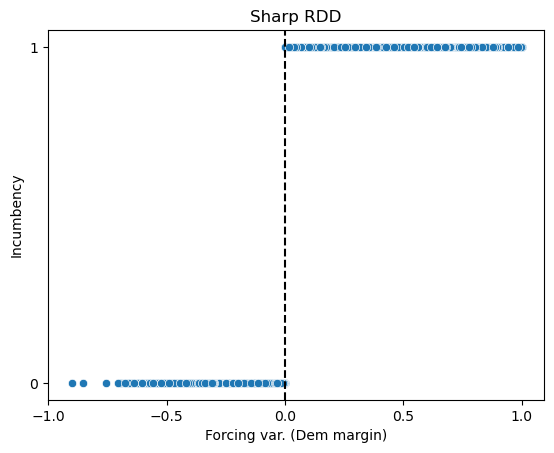

In [33]:
# Creating forcing variable.
data['fv'] = data['share'] - data['win'] * data['2nd_share'] - (1 - data['win']) * data['1st_share']


# Dropping redistricting years.
data = data[~data['yearel'].apply(lambda x: x % 10 in [0, 2])]


# Only examining Democrats.
dem_mask = data['party'] == 100
data_dems = data.loc[dem_mask]


# Create column for next year's margin.
data_dems = data_dems.assign(next=data_dems.groupby('distid')['share'].shift(-1))
data_dems.dropna(inplace=True)


# Graph to visualize RDD.
g = sns.scatterplot(x = 'fv', y = 'win', data = data_dems)

g.set_title('Sharp RDD')

g.set_ylabel('Incumbency')
g.set_yticks([0, 1])

g.set_xlabel('Forcing var. (Dem margin)')
g.set_xticks([-1.0, -0.5, 0, 0.5, 1.0])

g.axvline(x=0, linestyle='--', color='black', lw='1.5');

Clearly we have a sharp RDD! We can further verify this numerically with Pandas.

In [34]:
# Verify that rows with a FV > 0 also have a treatment = 1
verify_rdd1 = ((data_dems['fv'] > 0) == (data_dems['win']==1)).all()

# Verify that rows with a FV <= also have a treatment = 0
verify_rdd2 = ((data_dems['fv'] <= 0) == (data_dems['win']==0)).all()

print('Rows with a positive Dem margin get treated?', verify_rdd1)
print("Rows with a 0 or negative Dem margin don't get treated?", verify_rdd2)

Rows with a positive Dem margin get treated? True
Rows with a 0 or negative Dem margin don't get treated? True


Awesome! More evidence that we have a sharp RDD. We will now proceed to replicate Lee's estimate for the causal effect of incumbency.

##### Part III: RDD Implementation
We will now conduct a regression analysis to identify the effect of incumbency. First, we need to cluster our standard errors by district, decade, and state.

In [35]:
# Naming our columns to cluster on.
cluster_cols = data_dems['distid'].astype(str) + '_' + data_dems['decade'].astype(str) + '_' + data_dems['state'].astype(str)

We can now begin the regression analysis. Let's begin with a simple linear model with an interaction term between the treatment (win) and the forcing variable. The coefficient estimate for this variable $\beta_2$ will identify the causal estimate we're looking for. The linear model is then:
$$
fv_{i t+1} = \beta_0 + \beta_1 fv_{it} + \beta_2 win + \beta_3 fv_{it} \cdot win + \epsilon
$$
where fv is the forcing variable (Democratic margin) for election $t$, and win is our binary treatment variable, both for district $i$.

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4652      0.004    119.579      0.000       0.458       0.473
fv             0.2706      0.014     18.744      0.000       0.242       0.299
win            0.0755      0.006     12.474      0.000       0.064       0.087
fv:win         0.0755      0.018      4.085      0.000       0.039       0.112


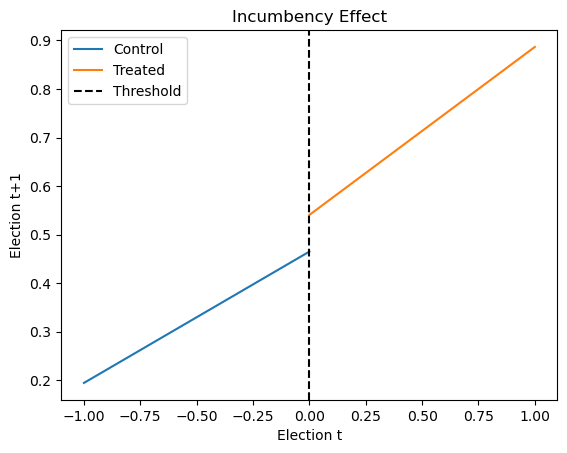

In [36]:
# Linear model specification and fitting.
linear_formula = 'next ~ fv + win + fv:win'
reg_lin = smf.ols(linear_formula, data=data_dems)

lin_result = reg_lin.fit(cov_type='cluster', cov_kwds={'groups': cluster_cols}, use_t=True)


# Display results.
print(lin_result.summary().tables[1])
my_functions.graph_linear(lin_result)

Looking at our table output, the coefficient $\beta_2 = 0.076$ shows us the treatment effect. That is the effect of incumbency on the margin in the next election. Note that this is almost identical to Lee's estimate of $0.077$. The standard error of $0.006$ implies statistical significance, meaning we successfully identified the treatment effect.

The following graphs show the forcing variable's quadratic, cubic, and quartic specifications, which yield similar results.

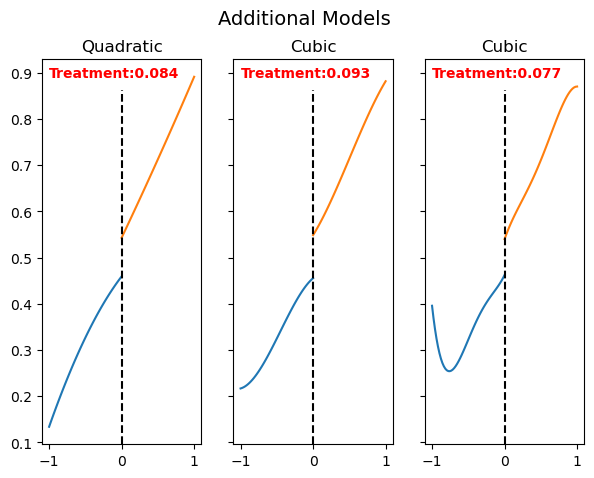

In [37]:
from more_models import models_class

add_models = models_class(data_dems)
add_models.fit()
add_models.graph_models()

##### References:

Lee DS (2008) Randomized experiments from non-random selection in US House elections. Journal of Econometrics 142(2): 675–697.

Thistlethwaite, D. L., & Campbell, D. T. (1960). Regression-discontinuity analysis: An alternative to the ex post facto experiment. Journal of Educational Psychology, 51(6), 309–317
